# Exploritory Data Analysis

## Abstract

We examine the train Exit and Entry traffic for the King Cross, Newtown and Parramatta stations for evidence of changes due to the introduction of the NSW Lockout Law on 24-Feb-2014.  Using the Baysian Change Point detection algorithm we found:
1. No evidence of changes to Kings Cross or Parramatta Exit traffic from the introduction of the lockout law.
2. Evidence of strong growth in the Parramatta Friday night Exit traffic that is independent of the lockout laws and which has increased traffic by ~200% since Jan-2013
2. Evidence of changes in the Newtown Friday night Exit traffic as a result of the lockout laws and which has increased traffic by 300%.

## The Data 
We were provided with train turnstile "validation" data by Transport for NSW. This data is a summary of Exit and Entry traffic by Station, Hour and Date. 

The data covers the period 2013-02-01 to 2016-07-31, for Friday, Saturday and Sunday nights from 5PM to 2AM. Since spans the transition from paper Magnetic Strip to OPAL cards the data is further divided by Source.

In the notebook [1_Data_Transformation](1_Data_Transformation.ipynb) we transform the data from its raw form to one more suitable for our analysis. Specifically we need observations between midnight and the last train (2pm) to have the Date as the previous day. This means all observation in the period 5pm-2am will have the same Date and be considered part of the same Night. 

In [1]:
import numpy as np
import pandas as pd
from datetime import timedelta, datetime

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 2)

import seaborn as sns
sns.set(font_scale=0.6)

import outlier
import utilities as util

Use scipy logsumexp().


In [2]:
df_raw = pd.read_pickle("TrainValidationData/df_raw.pkl") 
df_hourly = pd.read_pickle("TrainValidationData/df_hourly.pkl")
df_daily = pd.read_pickle("TrainValidationData/df_daily.pkl")
df_daily_changes = pd.read_pickle("TrainValidationData/df_daily_changes.pkl")

In the notebook [2_Cleaning](2_Cleaning.ipynb) we examine the data in more detail. Unsurprisingly we found some data is missing, however we conclude the impact is minimal and we can work with this data.

Counting the number of whole days of missing data we find:

In [3]:
daily = df_raw.reset_index().pivot_table(index = 'Date', columns = ['Station'], values='Exit', aggfunc=sum)
print("Number of days", len(daily))
for station in daily.columns:
    print("{:>22}: {:}".format(station, daily[station].isnull().sum()))

Number of days 549
Bondi Junction Station: 11
       Central Station: 2
 Circular Quay Station: 13
   Kings Cross Station: 14
  Martin Place Station: 10
        Museum Station: 16
       Newtown Station: 58
  North Sydney Station: 12
    Parramatta Station: 6
      St James Station: 17
     Town Hall Station: 0


From which we observe most stations are missing 1% to 2% of day, however Newtown Station is missing 10% (40 days). We examine the missing data more closely in [2_Cleaning](2_Cleaning.ipynb) and discover the missing data for:
1. Kings Cross and Parramatta is a few whole days on Saturday which is probably due to the station being closed for station or trackwork.
3.  Newtown is largely the first 5 months of Saturday data from Feb to June of 2013. This is probably a result of the station upgrade works started in 2013.

Counting the missing data by Hour of the day we get:

In [4]:
(df_raw.reset_index().pivot_table(index = 'Date', columns = ['Station', 'Hour'], values='Exit', aggfunc=sum).
             isnull().
             sum().reset_index().
             pivot('Station', 'Hour', 0))

Hour,5PM,6PM,7PM,8PM,9PM,10PM,11PM,12AM,1AM,2AM
Station,,,,,,,,,,
Bondi Junction Station,25,23,26,29,26,61,69,61,187,498
Central Station,2,2,2,2,2,5,6,6,6,33
Circular Quay Station,27,27,27,30,30,33,32,20,214,528
Kings Cross Station,27,26,28,29,29,30,29,23,134,499
Martin Place Station,21,22,24,23,25,62,92,142,272,525
Museum Station,32,36,36,35,36,119,118,127,290,536
Newtown Station,93,92,96,112,111,178,197,184,319,470
North Sydney Station,29,28,26,30,29,29,30,21,132,491
Parramatta Station,15,12,15,13,18,19,20,15,76,403


We for observe for some stations (Central, Kings Cross, Paramatter) the missing data does not change by Hour. For others, the count of increases later at night possibly indicating that the station closes early or the gates are left open and people do not swipe off. 

## Analysis of Hourly Traffic 

In this section we look at the traffic patterns at the hourly level. This data is created from the raw data by adding the Exit/Entry traffic for Magnetic Tickets and OPAL for each Station/Date/Hour.

The trellis plot below list Nights from left to right and Stations from top to bottom. Each plot displays the average Exit traffic by hour from 5PM - 2AM

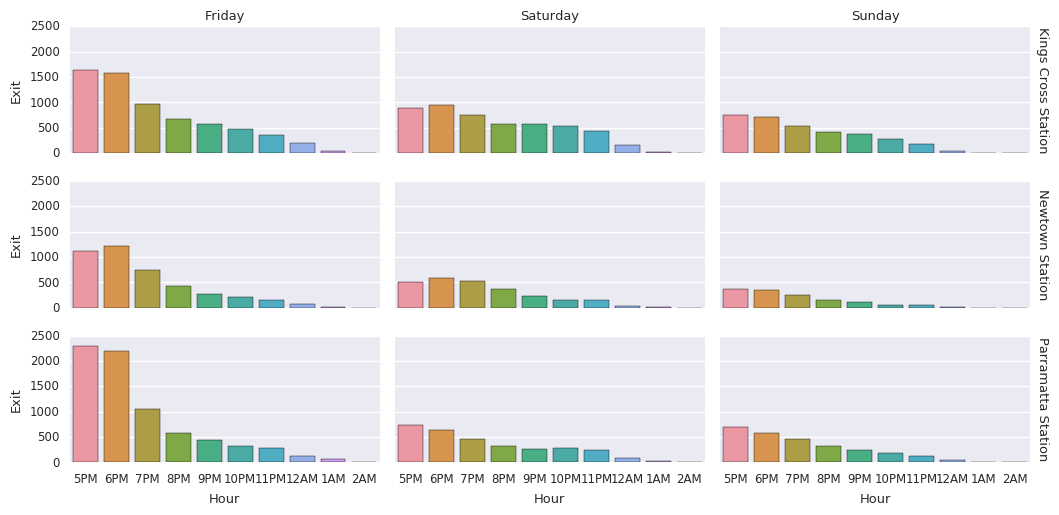

In [5]:
sns.set(font_scale=0.85)
df_hourly['Year']    = df_hourly.index.year
stations= ['Kings Cross Station', 'Newtown Station', 'Parramatta Station']

g = sns.factorplot(data=df_hourly, x='Hour', y='Exit', kind="bar", 
               row="Station", row_order=stations, col = 'Night',
               size=1.75, aspect=2, ci = None, margin_titles = True)
util.set_titles(g);

We observe:
- Exit traffic generally declines by Hour as expected.
- On Friday night the 5pm and 6pm Exit traffic is much higher than on Saturday or Sunday, especially in  Parramatta. It is also disproportionate to the rest of the night. We suspect this to be commuters heading home from work. 

For this reason in subsequent analysis only consider data from 7pm onwards.

The following trellis plot list Stations from left to right and Hours from top to bottom (starting at 7PM). Note the X and Y scales are common across the plots to make comparison easy.  

Each each plot shows:
- The Exit volume (blue line). Note the yearly growth is shown in the legend.
- A trend line (dotted green), calculated using linear regression (ordinary least squares). Note this is indicative only.
- Outliers (red star), found using the [Interquartile Range (IQR) method](http://colingorrie.github.io/outlier-detection.html).

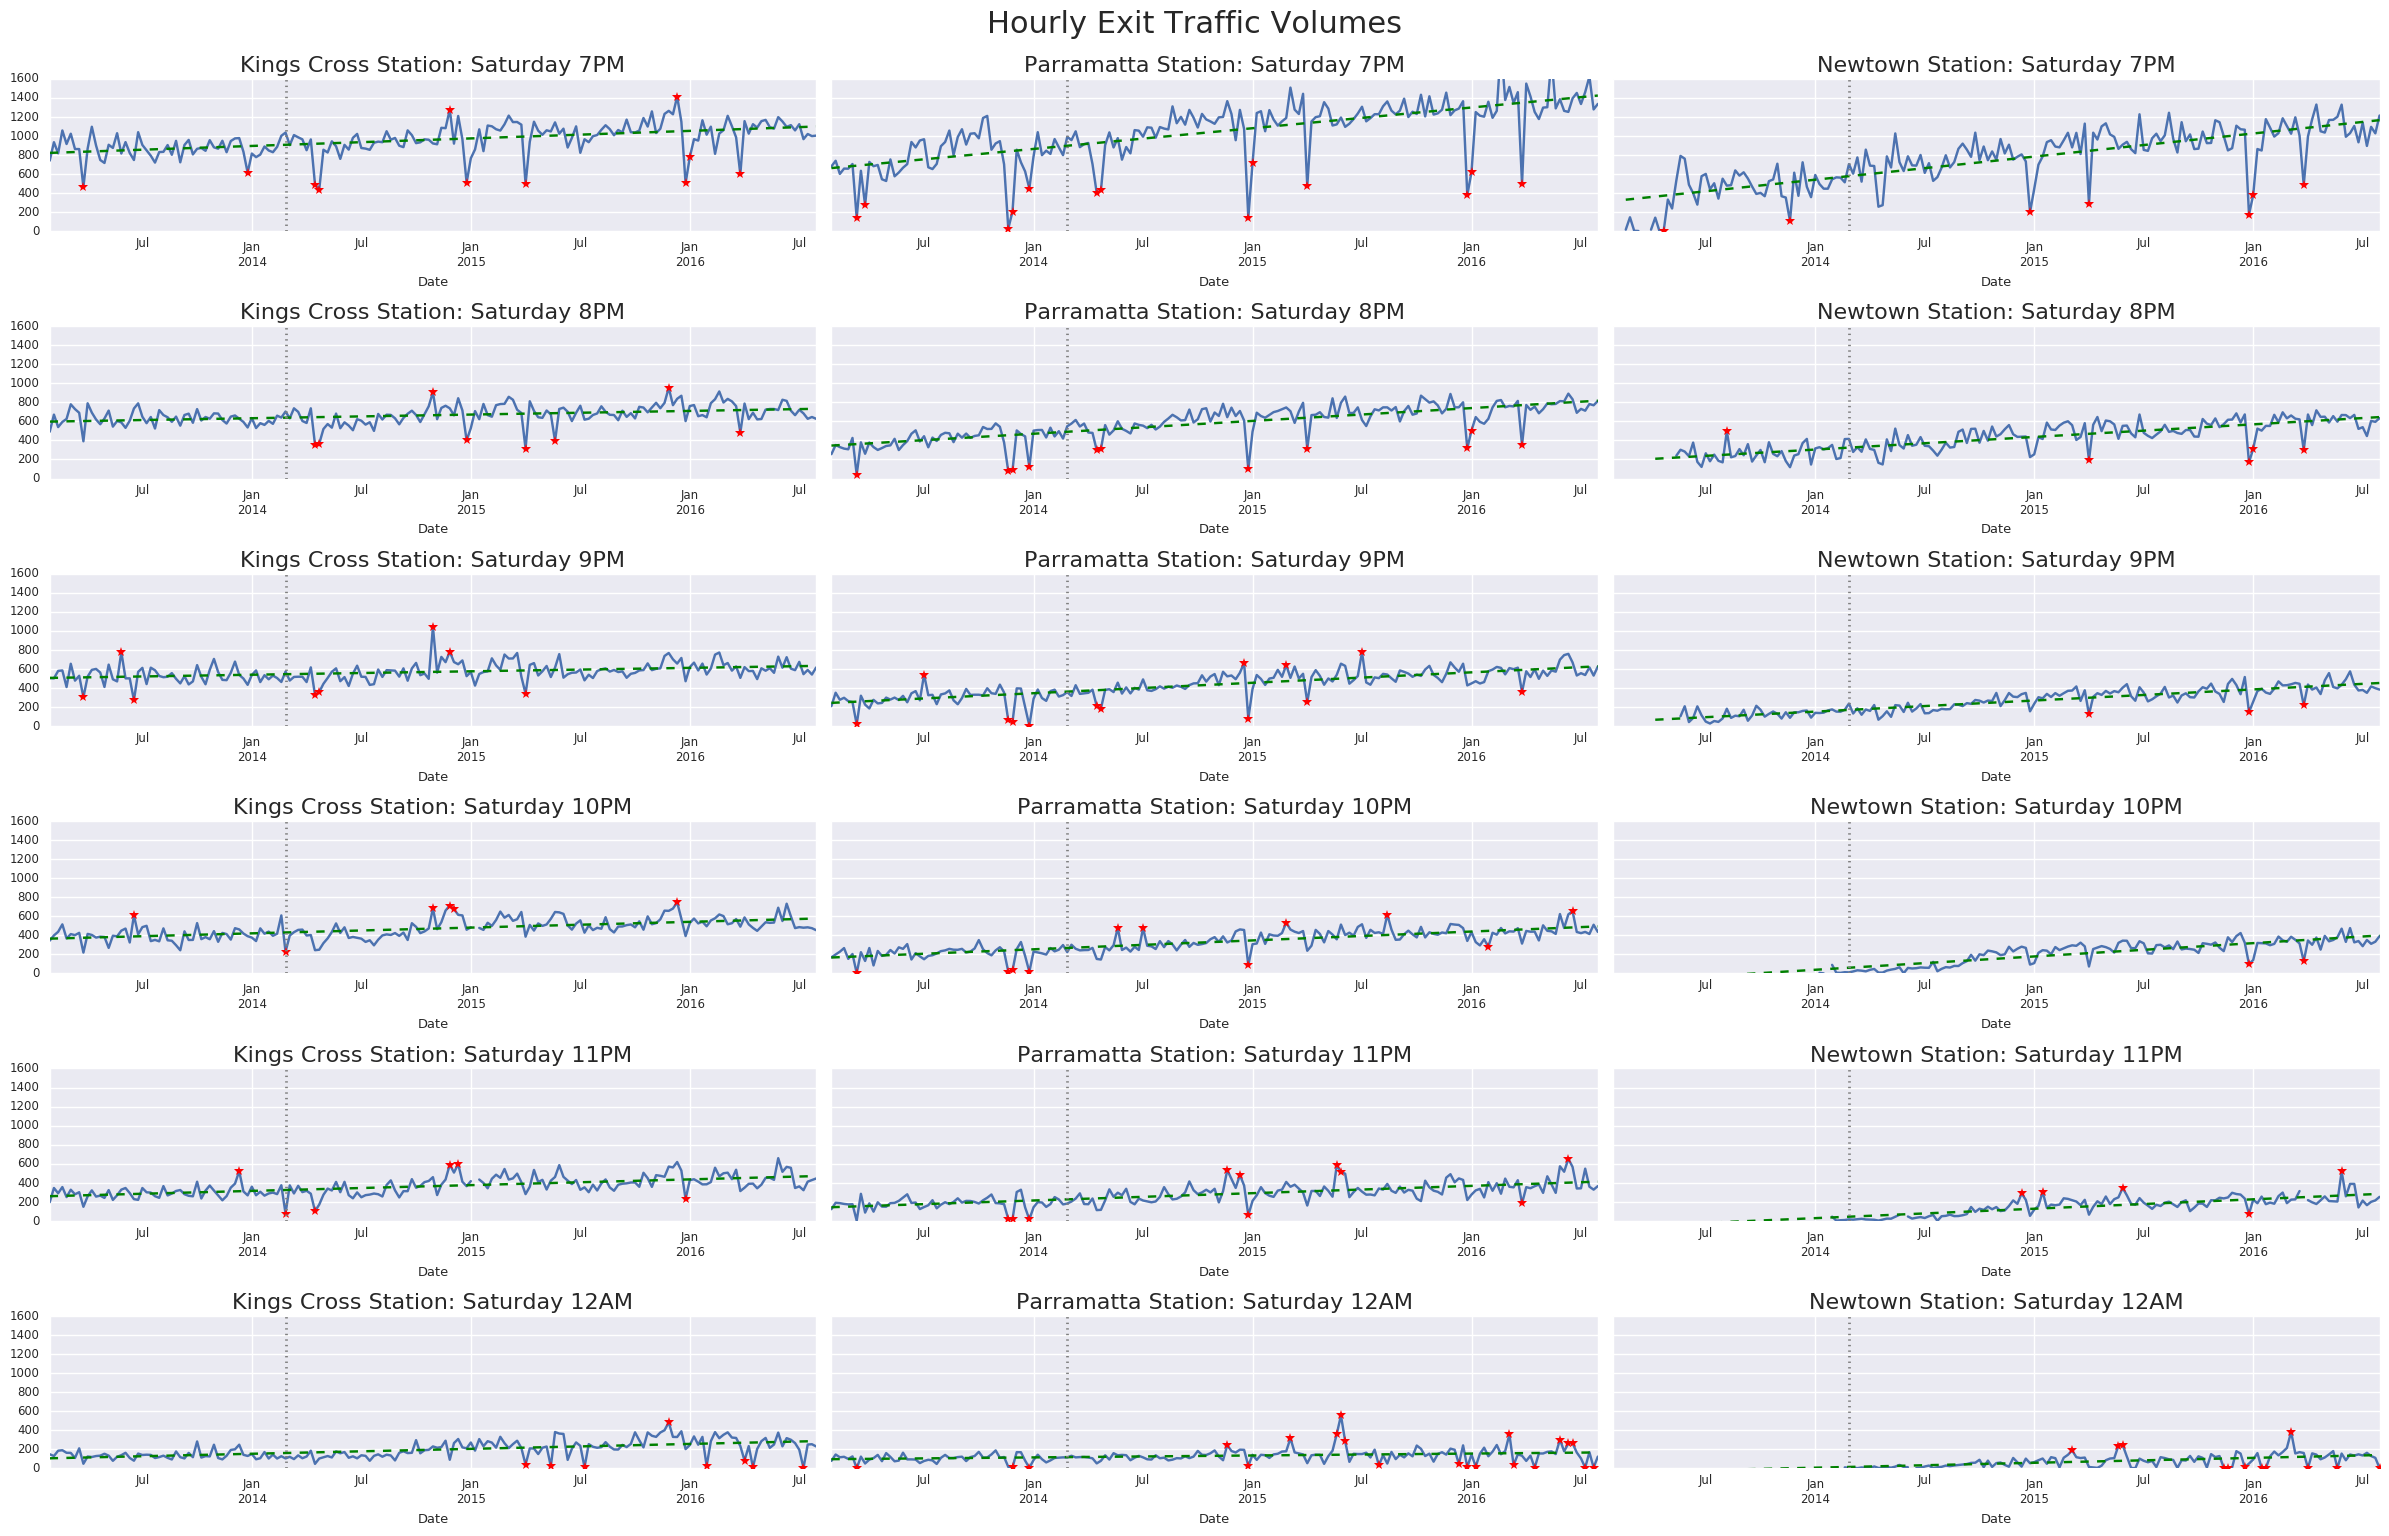

In [6]:
util.plot_stations_hourly(df_hourly,["Kings Cross Station", "Parramatta Station", 'Newtown Station'])

From these plots we observe that each time series:
1. Has  2-3 outliers per year (5%). As this does not impact our analysis they have not been investigated further. 
2. All stations show growth over the years, with Newtown and Parramatta are growing about 2 times faster than Kings Cross.
3. Is noisy. While the Exit traffic generally increases over time there are significant weekly variations (20-30%). The autocorrelation plot of the residues (below) indicates the variations are non-periodic, i.e., random rather than seasonal. 

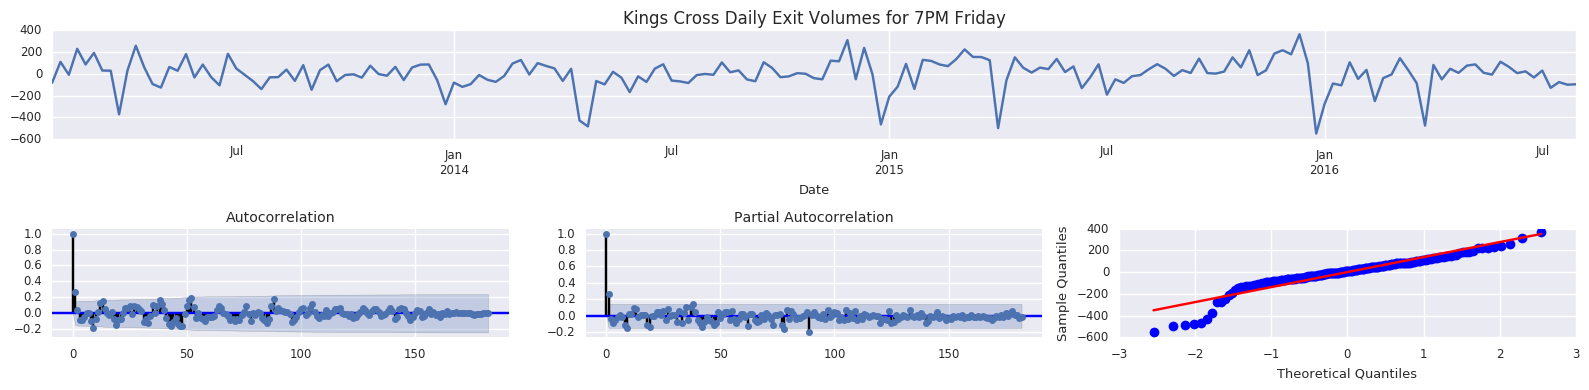

In [7]:
ts = (df_hourly.query('Station == "Kings Cross Station" and Night == "Friday" and Hour == "7PM"').
          groupby(level='Date')['Exit', 'Entry'].sum())

plt.figure(figsize=(16,4))
util.plot_autocorrelation(outlier.residue(ts.Exit), "Kings Cross Daily Exit Volumes for 7PM Friday")

Note: To check for seasonality it is necessary to remove the trend by subtracting the line of best fit leaving what is referred to as residues.

## Analysis of Daily Traffic

In this section we examine the Exit traffic at a daily level. Daily data is constructed from the hourly data by adding together the Exit traffic between 7PM and the last train for each Station/Date. We exclude Exit traffic before 7PM as it is heavily influenced by commuter traffic

The trellis plot below list Stations from left to right and Nights from top to bottom.

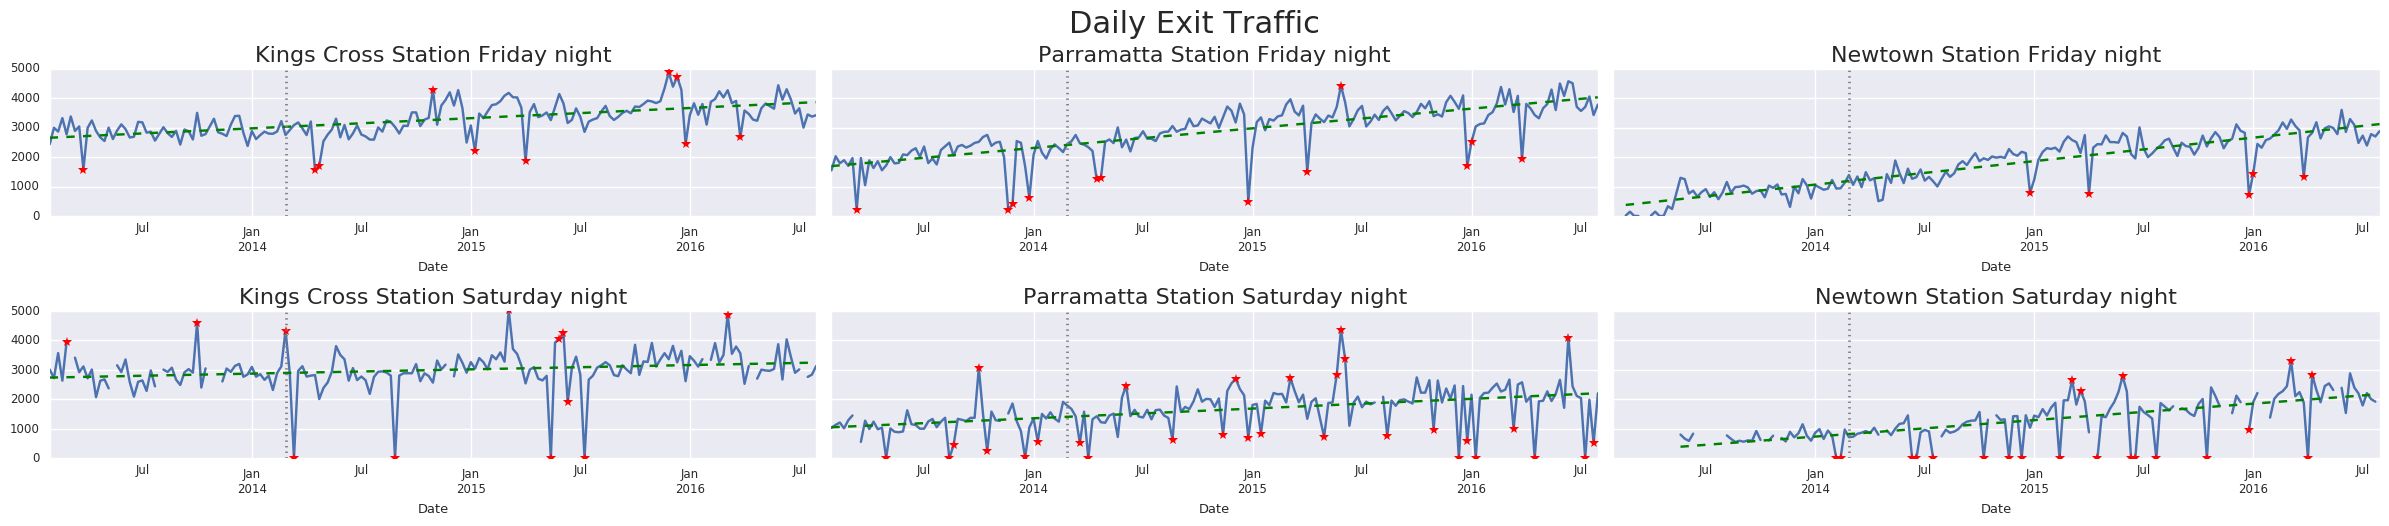

In [8]:
util.plot_stations_daily(df_daily,["Kings Cross Station", "Parramatta Station", 'Newtown Station'])

As with the hourly data, the autocorrlation plots of the residues indicates no seasonality.

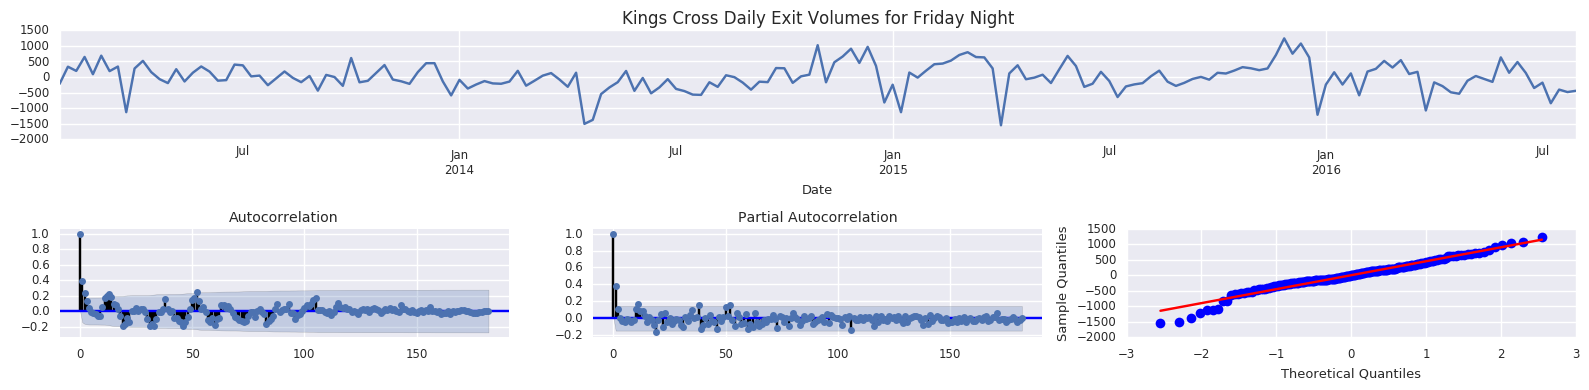

In [9]:
ts = (df_daily.query('Station == "Kings Cross Station" and Night == "Friday"').
          groupby(level='Date')['Exit', 'Entry'].sum())

plt.figure(figsize=(16,4))
util.plot_autocorrelation(outlier.residue(ts.Exit), "Kings Cross Daily Exit Volumes for Friday Night")

## Change Points

To test if the traffic changed due to the lockout laws we use Baysian Change Point (BCP) detection. This algorithm is well suited to our needs as it works by finding changes in the underlying mechanism that generates the time series.

Computing Baysian Change Point across all the Stations takes about 30 min and is done in the notebook [4_Change_Point_Detection](4_Change_Point_Detection.ipynb) and stored for later use.

### Kings Cross

To visualise the Baysian Change Points we use the a plot (below) where the time series is drawn in the upper chart and the probability of a change in the lower. We have also drawn a dotted vertical line to show the date the lockout laws were introduced. 

#### Friday
In this example the lower plot clearly indicates a change (30%) in Sept 2014, with the most probable date being 19-Sept. 

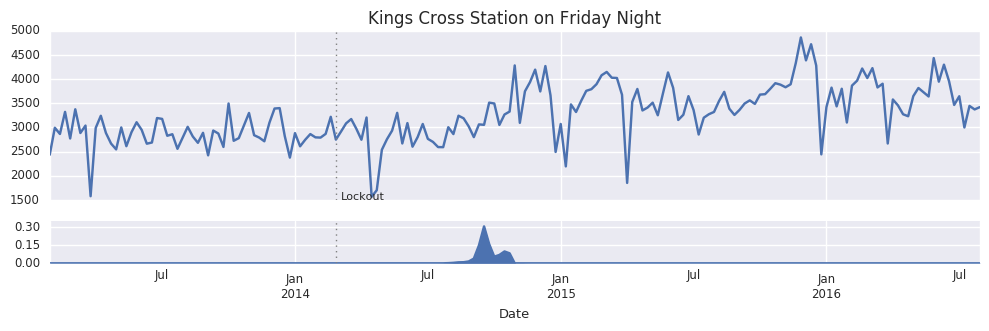

In [10]:
util.plot_bcp(df_daily_changes, "Kings Cross Station", "Friday");

We then annotate the Baysian Change Points plot with:
- Orange vertical lines were a change is predicted by the algorithm, in this case 19-Sept-2014.
- Fitting trend lines to each segment, in this case just two, one before 19-Sept-2014 (green) and one after (red).

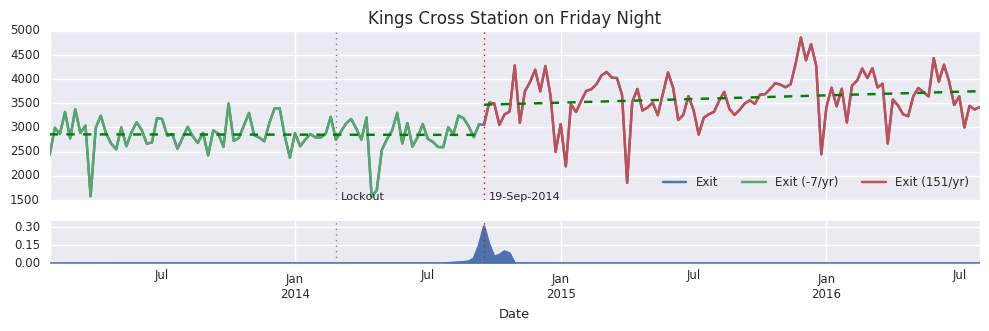

In [11]:
ts, axes = util.plot_bcp(df_daily_changes, "Kings Cross Station", "Friday")
util.mark('19-Sep-2014', axes)
outlier.plot(ts[:'12-Sep-2014'].Exit, ax=axes[0])
outlier.plot(ts['16-Sep-2014':].Exit, ax=axes[0])
axes[0].legend(loc='best', ncol = 3);

From this we can see the Exit traffic is flat up to 19-Sept-2014, then it jumps about 500 Exits/day and grows slowly (151 Exits/yr). 

This a surprising finding as it is 6 months after the lockout law, however a visual inspection of support this and as the probability (30%) is reasonably high it needs investigating.  One possible cause is the change from the old Magnetic Tickets to OPAL cards. This is shown below by plotting the same data broken by source. 

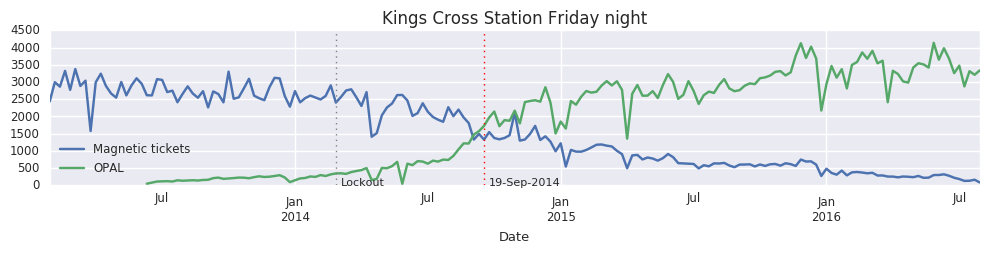

In [12]:
ax = util.plot_source(df_raw, "Kings Cross Station", "Friday")

util.mark(['19-Sep-2014'], [ax]);
plt.legend(loc='lower left');

We observe the detected change occurs when the OPAL card usage exceeds Magnetic Ticket. Finding this change is consistent with the way the BCP algorithm works, i.e., it finds changes in the underlying mechanism that generates the data.  In this case the change in mechanism is the relative increase in OPAL card Exits vs Magnetic ticket. 

These two ticketing mechanisms are subtly different as OPAL forces riders to "tap off" where as Magnetic tickets do not. This means for a constant number of riders as the ratio of OPAL to Magnetic tickets increases the Exit traffic will increase due to higher reporting rates. This suggests the jump in Sept is due to the higher reporting of Exits from OPAL and the switch from flat to slow growth in trend is probably an artifact of the relative increase in OPAL usage.  

It is also worth noting there is no evidence of any change around the time of the lockout laws.

Plotting the Baysian Change Point for Saturday night yields the following:

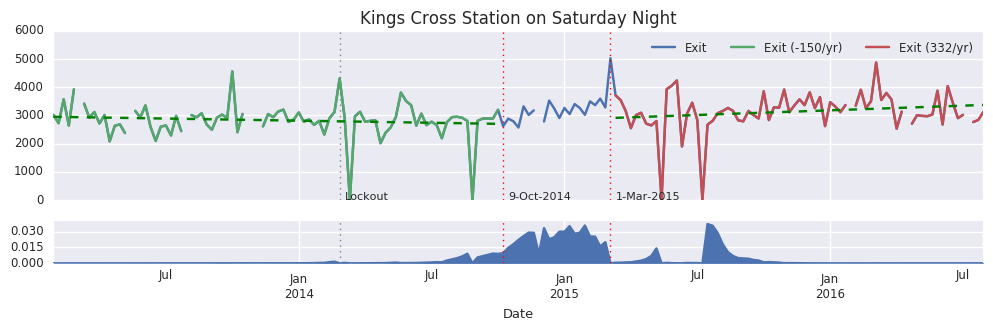

In [13]:
ts, axes = util.plot_bcp(df_daily_changes, "Kings Cross Station", "Saturday")
util.mark(['9-Oct-2014', '1-Mar-2015'], axes)
outlier.plot(ts[:'9-Oct-2014'].Exit, ax=axes[0])
outlier.plot(ts['8-Mar-2015':].Exit, ax=axes[0])
axes[0].legend(loc='best', ncol = 3);

#### Saturday
The BCP algorithm detects a low change probability (3%) spread across 5 month period (Oct-2014 to Feb-2015), which is much less clear that for the Friday. 

Examining the Source plot below we infer the detected change is also due to the switch from Magnetic tickets to OPAL, however it has a lower, broader probability profile as this switch is more gradual than on Fridays.

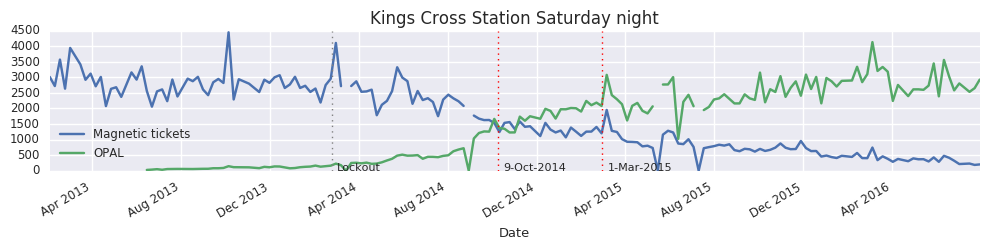

In [15]:
ax = util.plot_source(df_raw, "Kings Cross Station", "Saturday")

util.mark(['9-Oct-2014', '1-Mar-2015'], [ax])
plt.legend(loc='lower left');

### Parramatta

#### Friday
From the BCP and Source plots below we conclude there isn't a change in Exit traffic from the lockout law, however the BCP algorithm again has found the crossover for Magnetic ticket and OPEL usage. 

We  note there appears to be a real growth in Parramatta Exit traffic of around 500 per year which over the three and a half years is a 100% growth.  

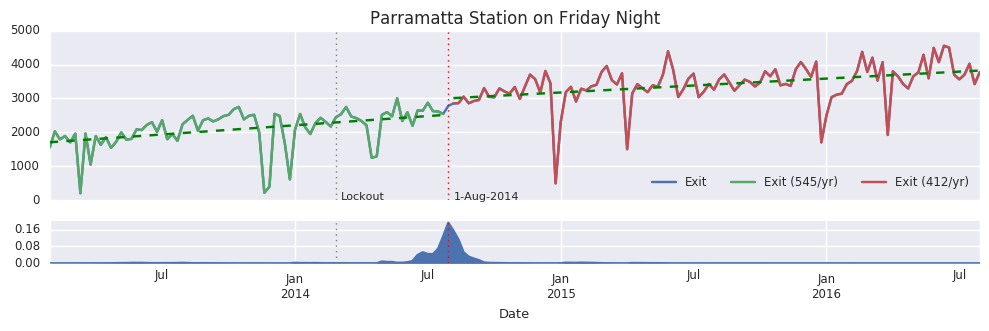

In [19]:
ts, axes = util.plot_bcp(df_daily_changes, "Parramatta Station", "Friday")
util.mark('1-Aug-2014', axes)

outlier.plot(ts[:'25-July-2014'].Exit, ax=axes[0])
outlier.plot(ts['8-Aug-2014':].Exit, ax=axes[0])
axes[0].legend(loc='best', ncol = 3);

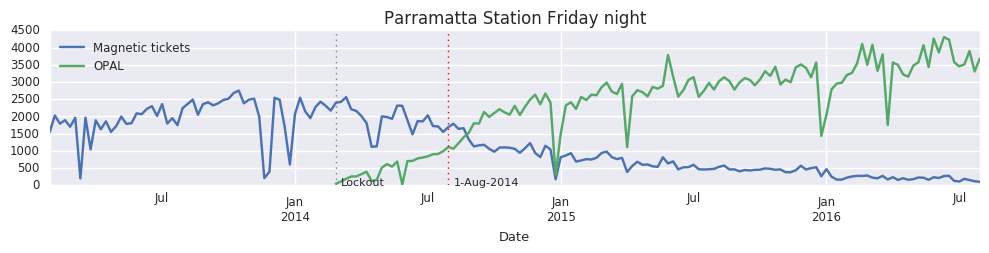

In [23]:
ax = util.plot_source(df_raw, "Parramatta Station", "Friday")

util.mark('1-Aug-2014', [ax])
plt.legend(loc='best');

#### Saturday

From the BCP and Source plots below we again conclude there isn't a change in Exit traffic from the lockout law, however the BCP algorithm again has again found the crossover for Magnetic ticket and OPEL usage. 

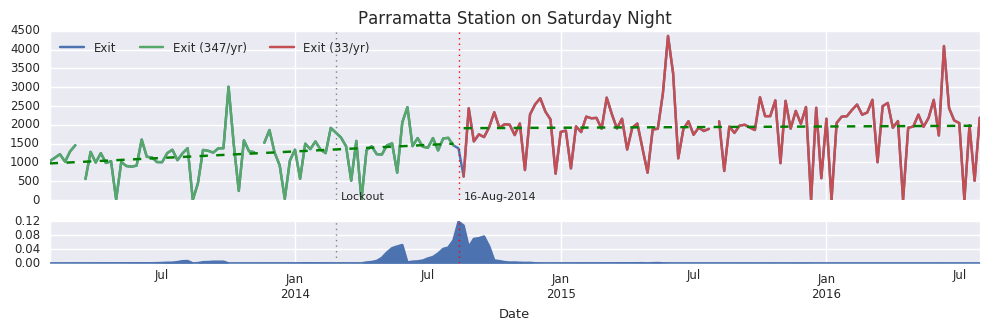

In [29]:
ts, axes = util.plot_bcp(df_daily_changes, "Parramatta Station", "Saturday")
util.mark('16-Aug-2014', axes)

outlier.plot(ts[:'9-Aug-2014'].Exit, ax=axes[0])
outlier.plot(ts['23-Aug-2014':].Exit, ax=axes[0])
axes[0].legend(loc='best', ncol = 3);

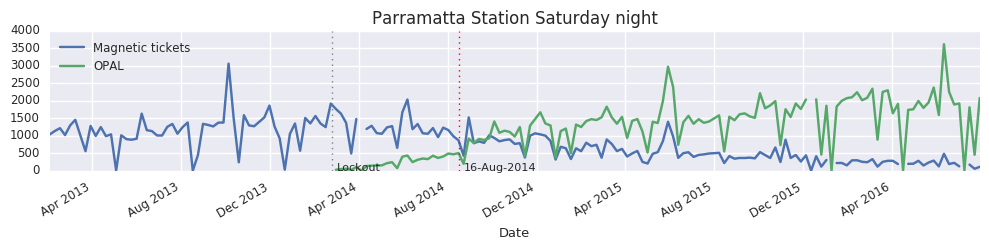

In [31]:
ax = util.plot_source(df_raw, "Parramatta Station", "Saturday")

util.mark('16-Aug-2014', [ax])
plt.legend(loc='best');

### Newtown

#### Friday

The BCP plot shows many more changes than for other stations. We conclude that 
- the very strong probability peaks in Jan and May of 2013 are due to the poor/missing data probably due to the station works.
- the change at 22-Aug-2014 is again due to OPEL usage overtaking Magnetic tickets.
- there is evidence of an increase directly after the lockout laws, specifically the probably peak in the BCP and the shift from flat before the lockout law date, to strong growth after. We believe this would have been much clear if not for the complications introduced by the switch to OPAL.

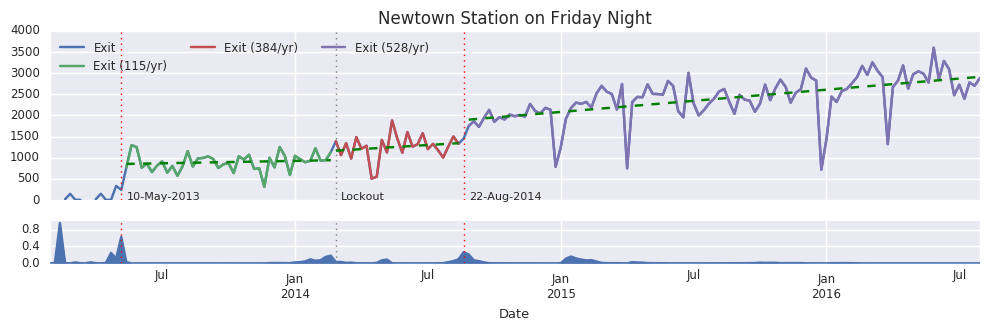

In [51]:
ts, axes = util.plot_bcp(df_daily_changes, "Newtown Station", "Friday")
util.mark('22-Aug-2014', axes)
util.mark('10-May-2013', axes)

outlier.plot(ts['17-May-2013':'21-Feb-2014'].Exit, ax=axes[0])
outlier.plot(ts['28-Feb-2014':'15-Aug-2014'].Exit, ax=axes[0])
outlier.plot(ts['29-Aug-2014':].Exit, ax=axes[0])
axes[0].legend(loc='best', ncol = 3);

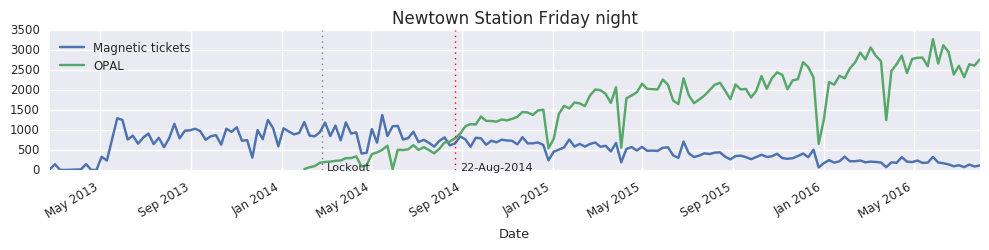

In [37]:
ax = util.plot_source(df_raw, "Newtown Station", "Friday")

util.mark('22-Aug-2014', [ax])
plt.legend(loc='best');

#### Saturday
The BCP plot for Saturday is difficult to interpret due large amount of missing data. 

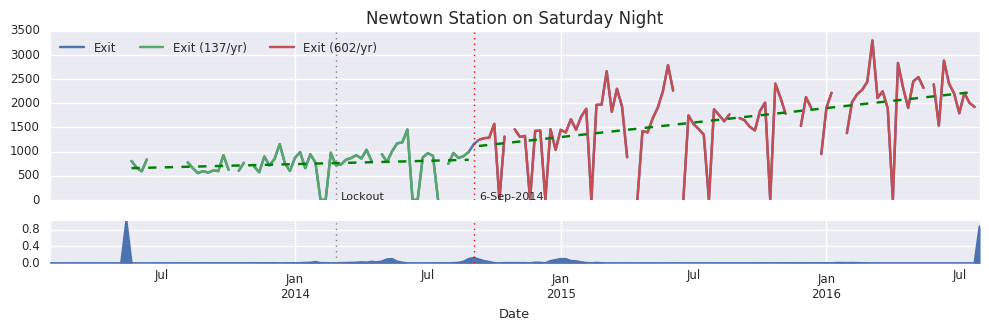

In [41]:
ts, axes = util.plot_bcp(df_daily_changes, "Newtown Station", "Saturday")
util.mark('6-Sep-2014', axes)

outlier.plot(ts[:'30-Aug-2014'].Exit, ax=axes[0])
outlier.plot(ts['13-Sep-2014':].Exit, ax=axes[0])
axes[0].legend(loc='best', ncol = 3);

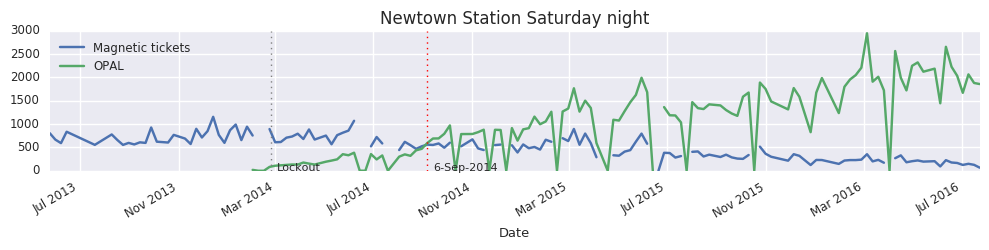

In [42]:
ax = util.plot_source(df_raw, "Newtown Station", "Saturday")

util.mark('6-Sep-2014', [ax])
plt.legend(loc='best');